# Ajuste del espectro 

Usa el método de cuadrados mínimos no-lineales

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import minimize

In [2]:
import danatools

## Datos

Datos bineados en $x = log_{10}(E/eV)$, y = número de eventos en el bin

In [3]:
xdata = np.linspace(18.45, 20.45, 21)
ydata = np.array([13023, 7711, 4478, 3159, 2162, 1483, 1052, 699, 451, 323, 200, 110, 43, 28, 23, 5, 2, 0, 1, 0, 0])

## Modelo

In [4]:
def modelo(x, theta):
    return np.power(10, theta[0]-theta[1]*(x-19) )

## Función de costo

In [5]:
def funcion_costo(theta, xdata, ydata):
        costo = np.zeros_like(theta[0])
        for (x1, y1) in zip(xdata, ydata):
            mu1 = modelo(x1, theta)
            residuo = y1 - mu1
            sigma_sqr = y1     # errores tomados de los datos (Pearson)
            costo += residuo**2 / sigma_sqr
        return costo

In [6]:
xfit, yfit = xdata[3:11], ydata[3:11]

In [7]:
xfit

array([18.75, 18.85, 18.95, 19.05, 19.15, 19.25, 19.35, 19.45])

In [8]:
yfit

array([3159, 2162, 1483, 1052,  699,  451,  323,  200])

In [9]:
J = lambda theta: funcion_costo(theta, xfit, yfit)

## Minimización

In [10]:
# La minimización no converge con la tolerancia por defecto
res = minimize(J, x0=(3, 2), tol=1e-6)
res

      fun: 4.508157233047195
 hess_inv: array([[ 1.15563295e-05, -2.10936802e-05],
       [-2.10936802e-05,  2.78824663e-04]])
      jac: array([4.73976135e-04, 8.46385956e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 142
      nit: 7
     njev: 44
   status: 2
  success: False
        x: array([3.08622272, 1.66648429])

In [11]:
# Hago la tolerancia menor al módulo del gradiente (jac)
res = minimize(J, x0=(3, 2), tol=1e-3)
res

      fun: 4.508157233047195
 hess_inv: array([[ 1.15572237e-05, -2.10383933e-05],
       [-2.10383933e-05,  2.78632732e-04]])
      jac: array([4.73976135e-04, 8.46385956e-06])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([3.08622272, 1.66648429])

## Estimadores

In [12]:
theta_est = res.x

## Errores

In [13]:
cova = 2*res.hess_inv
error = np.sqrt( np.diagonal(cova) )
rho = cova[0][1]/(error[0]*error[1])
print(f'a = {theta_est[0]:.3f} ± {error[0]:.3f}')
print(f'b = {theta_est[1]:.3f} ± {error[1]:.3f}')
print(f'ρ = {rho:.2f}')

a = 3.086 ± 0.005
b = 1.666 ± 0.024
ρ = -0.37


## Bondad del ajuste

In [14]:
costo_min = res.fun
ndof = len(xfit) - len(theta_est)
pvalor = chi2.sf(costo_min, ndof)
print(f'χ²min = {costo_min:.2f}')
print(f'ndof = {ndof}')
print(f'pvalor = {pvalor*100:.1f}%')

χ²min = 4.51
ndof = 6
pvalor = 60.8%


## Plot del ajuste

Ajuste

In [15]:
x = np.linspace( xfit.min(), xfit.max(), 256)
mu_est = modelo(x, theta_est)

Error del ajuste

In [16]:
grad_theta1 = math.log(10) * mu_est
grad_theta2 = (x-19) * math.log(10) * mu_est
grad = np.column_stack( (grad_theta1, grad_theta2) )
sigma_mu_est = danatools.fit_errors(grad, cova)

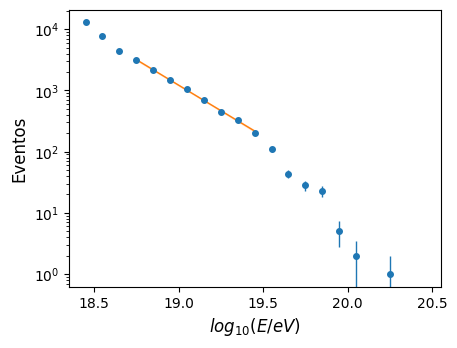

In [17]:
fig, ax = plt.subplots()
ax.set_xlabel('$log_{10}(E/eV)$')
ax.set_ylabel('Eventos')
ax.set_yscale("log")
ysigma = np.sqrt(ydata)
ax.errorbar(xdata, ydata, ysigma,ls='none', marker='o', ms=4, label='datos')
ax.plot(x, mu_est, label='Ajuste')
ax.fill_between(x, mu_est-sigma_mu_est, mu_est+sigma_mu_est, color='tab:orange', alpha=0.2)
plt.show()